
# Project Overview

Tanzania, with a population of over 57 million, faces significant challenges in providing access to clean water, a fundamental need for its citizens. The country has numerous water points spread across its vast landscape, but many of these wells have deteriorated over time. Some are fully functional, others require repair, and some have failed completely. This project focuses on building a classifier to predict the condition of these water wells, leveraging various data points such as the type of pump used, installation dates, geographic location, and other relevant factors. The outcome of this model will be crucial for organizations like NGOs and the Tanzanian government to prioritize and allocate resources effectively, ensuring better water access for the population.

# Business Understanding

Ensuring the functionality of water wells is critical to providing safe and clean water to communities, particularly in a developing country like Tanzania. The failure of these water points can have severe consequences, leading to water scarcity, poor hygiene, and health issues. For stakeholders such as the Tanzanian government and NGOs, understanding the factors that contribute to the deterioration of wells can drive strategic decisions, such as where to allocate repair resources or how to design more durable wells in the future. This project aims to address this need by developing a predictive model that can classify the condition of wells, enabling these stakeholders to act proactively in maintaining water accessibility.

# Objectives

The overarching goal of this project is to develop a robust and accurate classification model that can predict the condition of water wells in Tanzania. This model will assist in identifying wells that are likely to fail, enabling stakeholders to take preventive measures. By understanding the key factors influencing well functionality, the project will also provide insights that can be used to improve the design and maintenance of future water points. Ultimately, this project seeks to contribute to a more reliable water supply infrastructure in Tanzania, improving the quality of life for its residents.

## Main Objectives

The main objectives of this project include:

1. Analyzing the data to identify the most significant factors contributing to the condition of the wells.
2. Building a predictive model that can classify water wells into one of three categories: functional, in need of repair, or non-functional.
3. Providing actionable insights and recommendations to stakeholders, such as NGOs and the Tanzanian government, to guide their efforts in maintaining and improving water well infrastructure.

## Specific Objectives

To achieve the main objectives, the project will focus on the following specific objectives:

1. Conducting exploratory data analysis (EDA) to uncover patterns and relationships within the data.
2. Developing and fine-tuning a machine learning model for classification to predict well conditions.
3. Evaluating the model's performance using appropriate metrics to ensure accuracy and reliability.
4. Interpreting the model's results to provide clear, actionable recommendations for stakeholders.

# Data Understanding

The dataset for this project comprises detailed information on water wells across Tanzania, including variables such as; the type of pump installed, the year of installation, and the geographic coordinates of each well. Additional features may include the depth of the well, the source of water, and the materials used in construction. Understanding the distribution of these features and their potential impact on well functionality is crucial for building an effective classification model. 

#### Importing the necessary datasets

In [179]:
#Importing the necessary libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer


#### Loading the Datasets

In [180]:
#Import the necessary datasets
df_training_labels = pd.read_csv('Data\Training_Labels.csv', index_col= 0)
df_training_values = pd.read_csv('Data\Training_values.csv', index_col = 0)
df_test_values = pd.read_csv('Data\Test_set.csv', index_col = 0)

#### Inspecting the data

In [181]:
# Getting a preview of the first 5 rows of the training labels data
df_training_labels.head()

,status_group
id,
69572,functional
8776,functional
34310,functional
67743,non functional
19728,functional


In [182]:
# Getting a preview of the first 5 rows of the training values data
df_training_values.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,14/03/2011,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
8776,0.0,06/03/2013,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
34310,25.0,25/02/2013,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
67743,0.0,28/01/2013,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
19728,0.0,13/07/2011,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


#### Merging the data

In [183]:
# merging the training values and training labels dataset
df_training_set = df_training_values.merge(df_training_labels, on = "id")

# Getting a preview of the first 5 rows of the merged data
df_training_set.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
id,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,14/03/2011,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
8776,0.0,06/03/2013,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
34310,25.0,25/02/2013,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
67743,0.0,28/01/2013,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
19728,0.0,13/07/2011,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


#### Inspecting the merged data

In [184]:
# Getting a summary of the dataset
df_training_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59400 entries, 69572 to 26348
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             59400 non-null  float64
 1   date_recorded          59400 non-null  object 
 2   funder                 55763 non-null  object 
 3   gps_height             59400 non-null  int64  
 4   installer              55745 non-null  object 
 5   longitude              59400 non-null  float64
 6   latitude               59400 non-null  float64
 7   wpt_name               59398 non-null  object 
 8   num_private            59400 non-null  int64  
 9   basin                  59400 non-null  object 
 10  subvillage             59029 non-null  object 
 11  region                 59400 non-null  object 
 12  region_code            59400 non-null  int64  
 13  district_code          59400 non-null  int64  
 14  lga                    59400 non-null  object 
 15  war

In [185]:
# Checking the shape of the dataset
df_training_set.shape

(59400, 40)

In [186]:
# Getting the statistics of numerical columns
df_training_set.describe()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


# Data Cleaning

#### Dropping columns with information that is not relevant to prediction

In [187]:
# Identify columns with similar information
similar_columns = {
    'extraction_type': ['extraction_type_group', 'extraction_type_class'],
    'management': ['management_group'],
    'payment': ['payment_type'],
    'water_quality': ['quality_group'],
    'quantity': ['quantity_group'],
    'source': ['source_type', 'source_class'],
    'waterpoint_type': ['waterpoint_type_group']
}

# Drop the redundant columns, retaining only the first column of each group
columns_to_drop = [col for group in similar_columns.values() for col in group]
df_training_set = df_training_set.drop(columns=columns_to_drop)

# Dropping columns with information that is not relevant for prediction
df_training_set = df_training_set.drop(columns=['wpt_name','subvillage','num_private', 'recorded_by'])

# Display the shape of the resultant dataframe
df_training_set.shape

(59400, 27)

#### Handling Missing Data 

In [188]:
# Checking for missing values
total_values = 59400
missing_values = df_training_set.isnull().sum()

# Getting the percentage of missing values in each column
missing_percentage = (missing_values/total_values)*100
missing_percentage

amount_tsh            0.000000
date_recorded         0.000000
funder                6.122896
gps_height            0.000000
installer             6.153199
longitude             0.000000
latitude              0.000000
basin                 0.000000
region                0.000000
region_code           0.000000
district_code         0.000000
lga                   0.000000
ward                  0.000000
population            0.000000
public_meeting        5.612795
scheme_management     6.528620
scheme_name          48.501684
permit                5.144781
construction_year     0.000000
extraction_type       0.000000
management            0.000000
payment               0.000000
water_quality         0.000000
quantity              0.000000
source                0.000000
waterpoint_type       0.000000
status_group          0.000000
dtype: float64

In [189]:
#Dropping columns where the percentange of missing values is more than 20
columns_to_drop = missing_percentage[missing_percentage > 20].index
df_training_set = df_training_set.drop(columns=columns_to_drop)

# Impute specific columns with 'Unknown'
df_training_set[['scheme_management', 'funder', 'installer']] = df_training_set[['scheme_management', 'funder', 'installer']].fillna('Unknown')

# Create imputers for numerical and categorical features
numerical_imputer = SimpleImputer(strategy='median')  # For numerical columns
categorical_imputer = SimpleImputer(strategy='most_frequent')  # For categorical columns

# Impute numerical features
df_training_set[['population']] = numerical_imputer.fit_transform(df_training_set[['population']])

# Impute categorical features
df_training_set[['permit', 'public_meeting']] = categorical_imputer.fit_transform(df_training_set[['permit', 'public_meeting']])

# Checking for missing values
df_training_set.isnull().sum()

amount_tsh           0
date_recorded        0
funder               0
gps_height           0
installer            0
longitude            0
latitude             0
basin                0
region               0
region_code          0
district_code        0
lga                  0
ward                 0
population           0
public_meeting       0
scheme_management    0
permit               0
construction_year    0
extraction_type      0
management           0
payment              0
water_quality        0
quantity             0
source               0
waterpoint_type      0
status_group         0
dtype: int64

#### Checking for duplicates

In [190]:
# Identify duplicated index values
duplicated_index = df_training_set.index.duplicated()

# Display the rows with duplicated index values
duplicate_rows = df_training_set[duplicated_index]
duplicate_rows

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,basin,region,region_code,...,permit,construction_year,extraction_type,management,payment,water_quality,quantity,source,waterpoint_type,status_group
id,,,,,,,,,,,,,,,,,,,,,


#### Converting Datatypes

In [191]:
# Checking data types
df_training_set.dtypes

amount_tsh           float64
date_recorded         object
funder                object
gps_height             int64
installer             object
longitude            float64
latitude             float64
basin                 object
region                object
region_code            int64
district_code          int64
lga                   object
ward                  object
population           float64
public_meeting        object
scheme_management     object
permit                object
construction_year      int64
extraction_type       object
management            object
payment               object
water_quality         object
quantity              object
source                object
waterpoint_type       object
status_group          object
dtype: object

In [192]:
# Fixing the datatypes
df_training_set['date_recorded'] = pd.to_datetime(df_training_set['date_recorded'], format='%d/%m/%Y')

#### Feature engineering
Creating a decade column from the construction year decade

In [193]:
# Checking the value types of the construction column
df_training_set['construction_year'].value_counts()

construction_year
0       20709
2010     2645
2008     2613
2009     2533
2000     2091
2007     1587
2006     1471
2003     1286
2011     1256
2004     1123
2012     1084
2002     1075
1978     1037
1995     1014
2005     1011
1999      979
1998      966
1990      954
1985      945
1980      811
1996      811
1984      779
1982      744
1994      738
1972      708
1974      676
1997      644
1992      640
1993      608
2001      540
1988      521
1983      488
1975      437
1986      434
1976      414
1970      411
1991      324
1989      316
1987      302
1981      238
1977      202
1979      192
1973      184
2013      176
1971      145
1960      102
1967       88
1963       85
1968       77
1969       59
1964       40
1962       30
1961       21
1965       19
1966       17
Name: count, dtype: int64

In [194]:
# Imputing the zeros in the construction year column  with the median

# Calculate the median of the non-zero values in the 'construction_year' column
median_year = df_training_set['construction_year'].replace(0, np.nan).median()

# Impute zeros with the calculated median
df_training_set['construction_year'] = df_training_set['construction_year'].replace(0, median_year)

In [195]:
# Checking the value counts for the construction year column
df_training_set['construction_year'].value_counts()

construction_year
2000    22800
2010     2645
2008     2613
2009     2533
2007     1587
2006     1471
2003     1286
2011     1256
2004     1123
2012     1084
2002     1075
1978     1037
1995     1014
2005     1011
1999      979
1998      966
1990      954
1985      945
1996      811
1980      811
1984      779
1982      744
1994      738
1972      708
1974      676
1997      644
1992      640
1993      608
2001      540
1988      521
1983      488
1975      437
1986      434
1976      414
1970      411
1991      324
1989      316
1987      302
1981      238
1977      202
1979      192
1973      184
2013      176
1971      145
1960      102
1967       88
1963       85
1968       77
1969       59
1964       40
1962       30
1961       21
1965       19
1966       17
Name: count, dtype: int64

In [196]:
 # Creating the decade column
df_training_set['decade'] = df_training_set['construction_year']

In [197]:
df_training_set["decade"] = df_training_set['decade'].replace(to_replace = (1960,1961,1962,1963,1964,1965,1966,1967,1968,1969),
                        value ='60s')
df_training_set["decade"] = df_training_set['decade'].replace(to_replace = (1970,1971,1972,1973,1974,1975,1976,1977,1978,1979),
                        value ='70s')
df_training_set["decade"] = df_training_set['decade'].replace(to_replace = (1980,1981,1982,1983,1984,1985,1986,1987,1988,1989),
                        value ='80s')
df_training_set["decade"] = df_training_set['decade'].replace(to_replace = (1990,1991,1992,1993,1994,1995,1996,1997,1998,1999),
                        value ='90s')
df_training_set["decade"] = df_training_set['decade'].replace(to_replace = (2000,2001,2002,2003,2004,2005,2006,2007,2008,2009),
                        value ='00s')
df_training_set["decade"] = df_training_set['decade'].replace(to_replace = (2010,2011,2012,2013),
                        value ='10s')

In [198]:
df_training_set['decade'].value_counts() 

decade
00s    36039
90s     7678
80s     5578
10s     5161
70s     4406
60s      538
Name: count, dtype: int64

In [199]:
# Preview of the resultant dataframe
train_data = df_training_set
train_data.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,basin,region,region_code,...,construction_year,extraction_type,management,payment,water_quality,quantity,source,waterpoint_type,status_group,decade
id,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,Lake Nyasa,Iringa,11,...,1999,gravity,vwc,pay annually,soft,enough,spring,communal standpipe,functional,90s
8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Lake Victoria,Mara,20,...,2010,gravity,wug,never pay,soft,insufficient,rainwater harvesting,communal standpipe,functional,10s
34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Pangani,Manyara,21,...,2009,gravity,vwc,pay per bucket,soft,enough,dam,communal standpipe multiple,functional,00s
67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Ruvuma / Southern Coast,Mtwara,90,...,1986,submersible,vwc,never pay,soft,dry,machine dbh,communal standpipe multiple,non functional,80s
19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Lake Victoria,Kagera,18,...,2000,gravity,other,never pay,soft,seasonal,rainwater harvesting,communal standpipe,functional,00s


In [209]:
train_data.to_csv('cleaned_data.csv', index=False)

# Exploratory Data Analysis

## Univariate analysis

### Distribution of Well Conditions

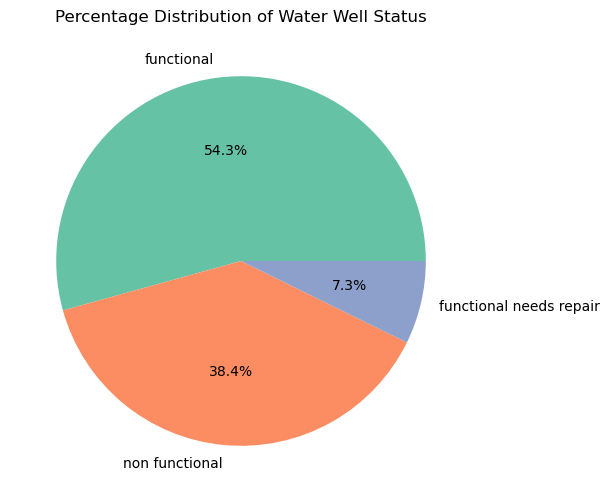

In [200]:
plt.figure(figsize=(8, 6))
status_counts = train_data['status_group'].value_counts()
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', colors=plt.get_cmap('Set2').colors)
plt.title('Percentage Distribution of Water Well Status')
plt.show()

54.3% of the Water wells are functional, 38.4% are non functional and 7.3% need repair.

### Distribution of Water Quality

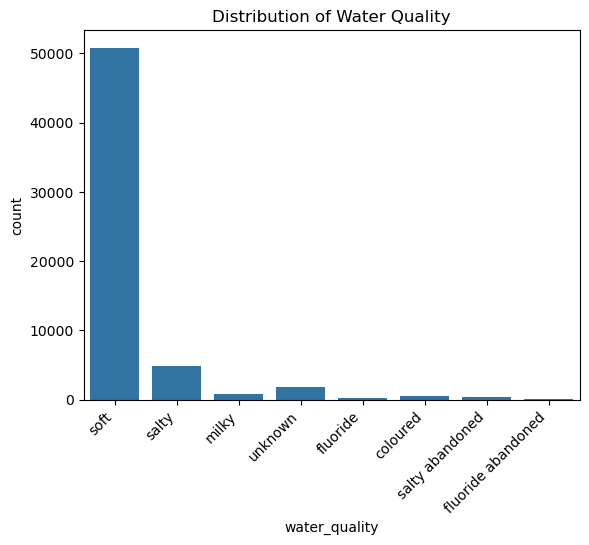

In [201]:
sns.countplot(x='water_quality', data= train_data)
plt.title('Distribution of Water Quality')
plt.xticks(rotation=45, ha='right')
plt.show()

### Top Ten Funders

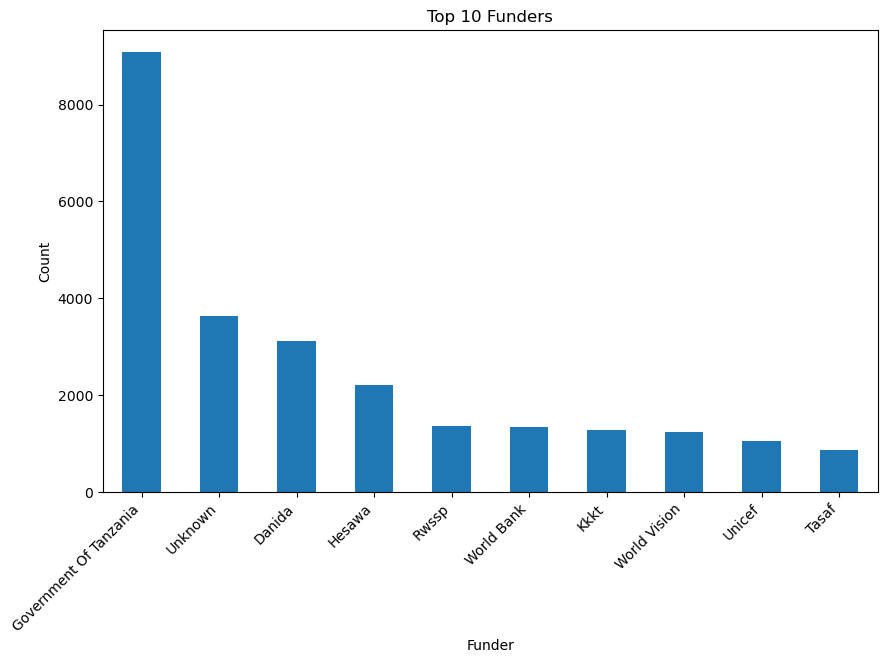

In [202]:
plt.figure(figsize=(10, 6))
train_data['funder'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Funders')
plt.xlabel('Funder')
plt.ylabel('Count')
plt.xticks(rotation = 45, ha='right')
plt.show()

### Pump Type distribution

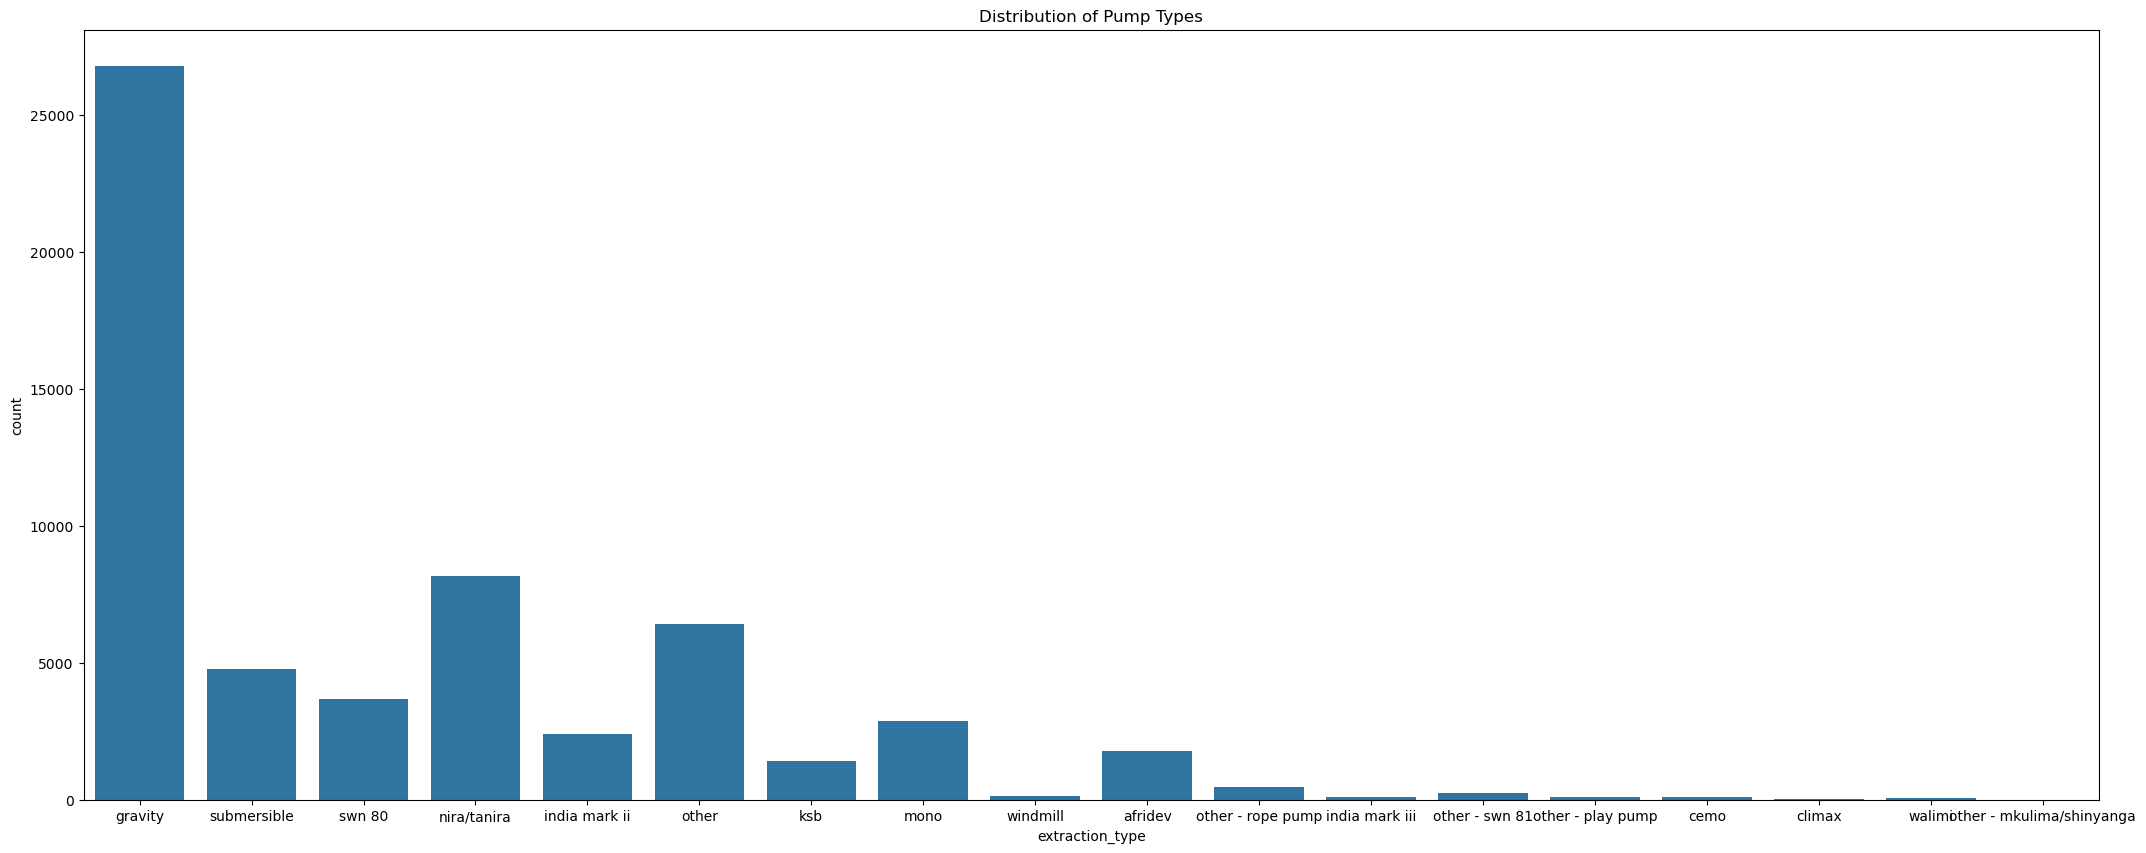

In [203]:
plt.figure(figsize=(26,10))
sns.countplot(x='extraction_type', data= train_data)
plt.title('Distribution of Pump Types')
plt.show()

### Geographical distribution of wells

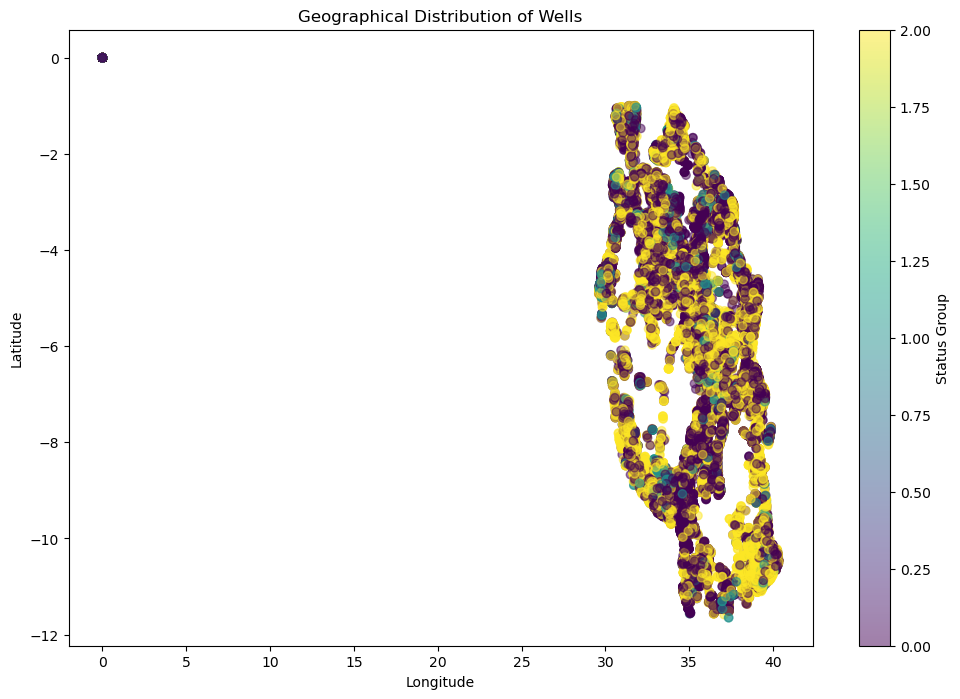

In [204]:
plt.figure(figsize=(12, 8))
plt.scatter(train_data['longitude'], train_data['latitude'], c= train_data['status_group'].astype('category').cat.codes, alpha=0.5)
plt.title('Geographical Distribution of Wells')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Status Group')
plt.show()

## Bivariate Analysis

### Pump Type vs Well Condition

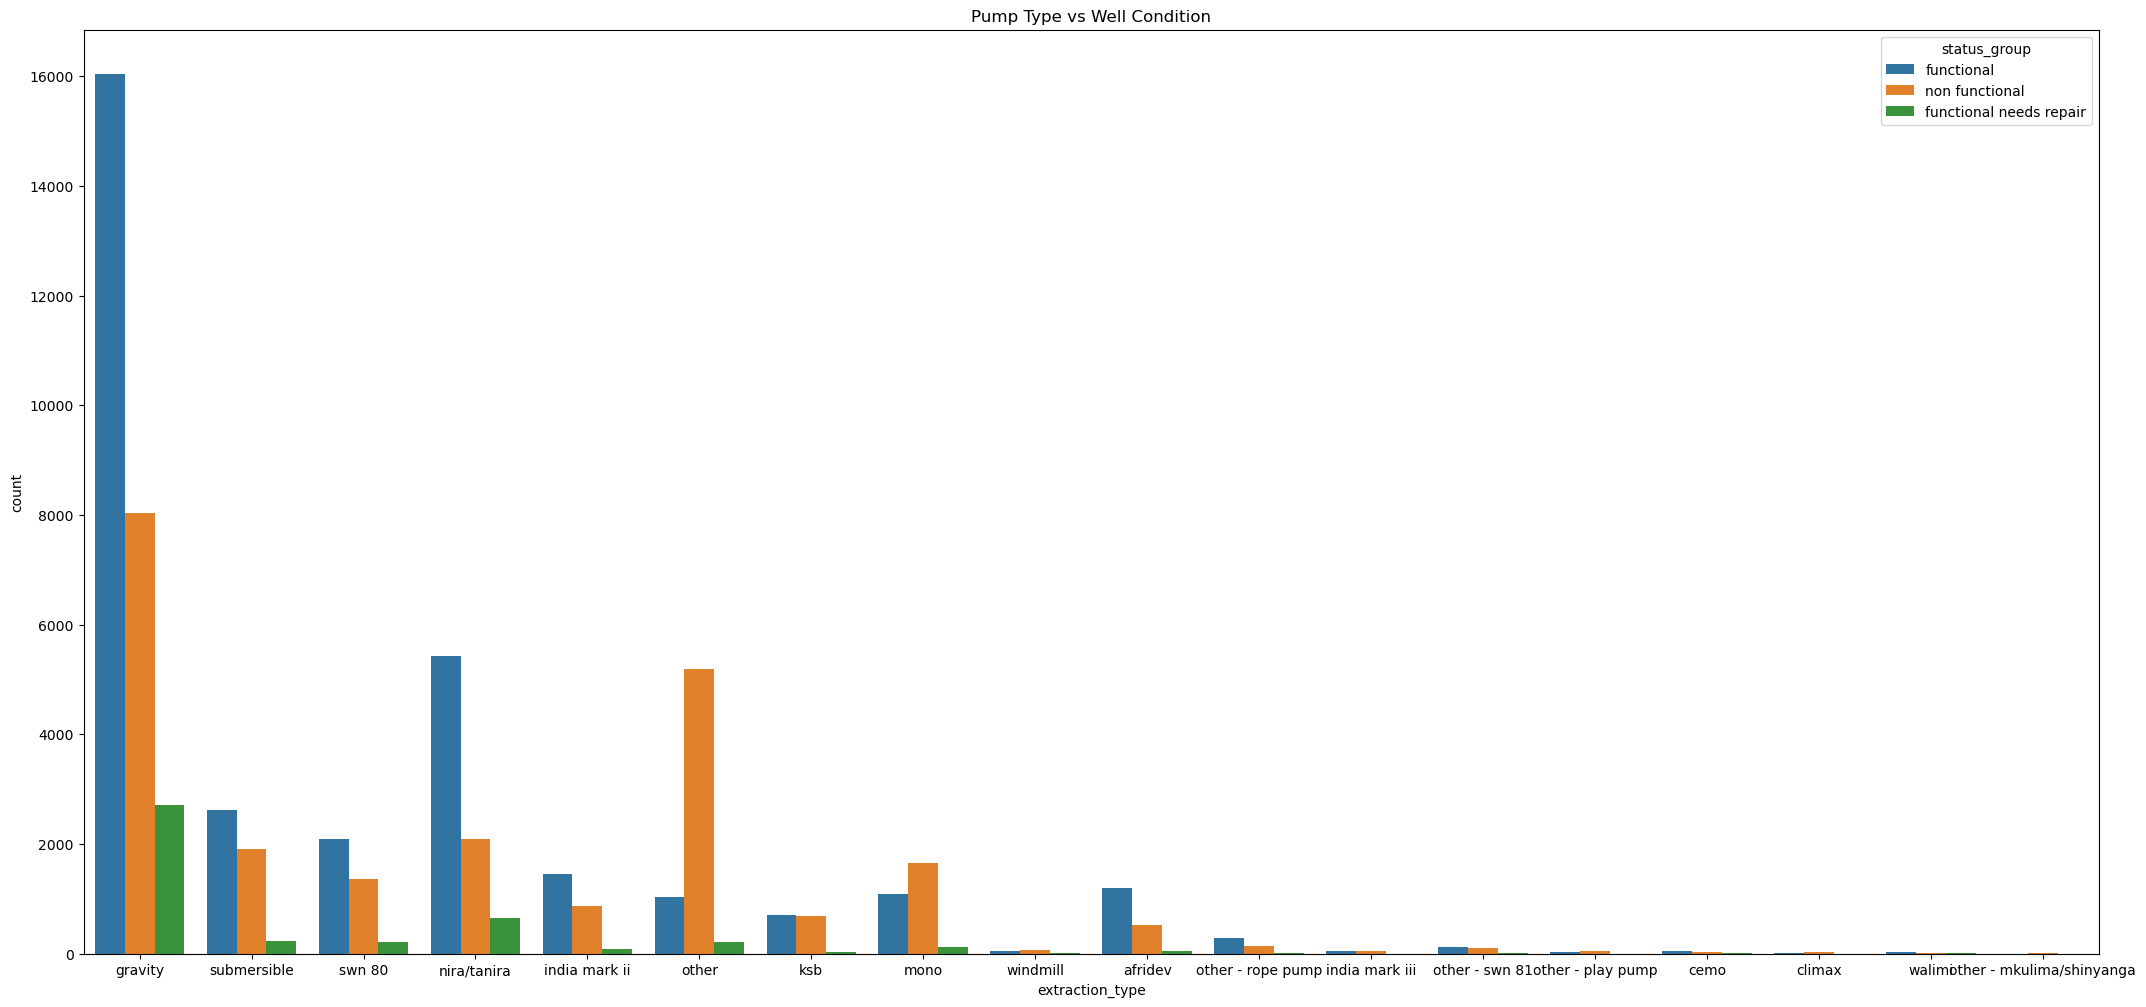

In [205]:
plt.figure(figsize=(26,12))
sns.countplot(x='extraction_type', hue='status_group', data= train_data)
plt.title('Pump Type vs Well Condition')
plt.show()

#### Water Quality VS Well Condition

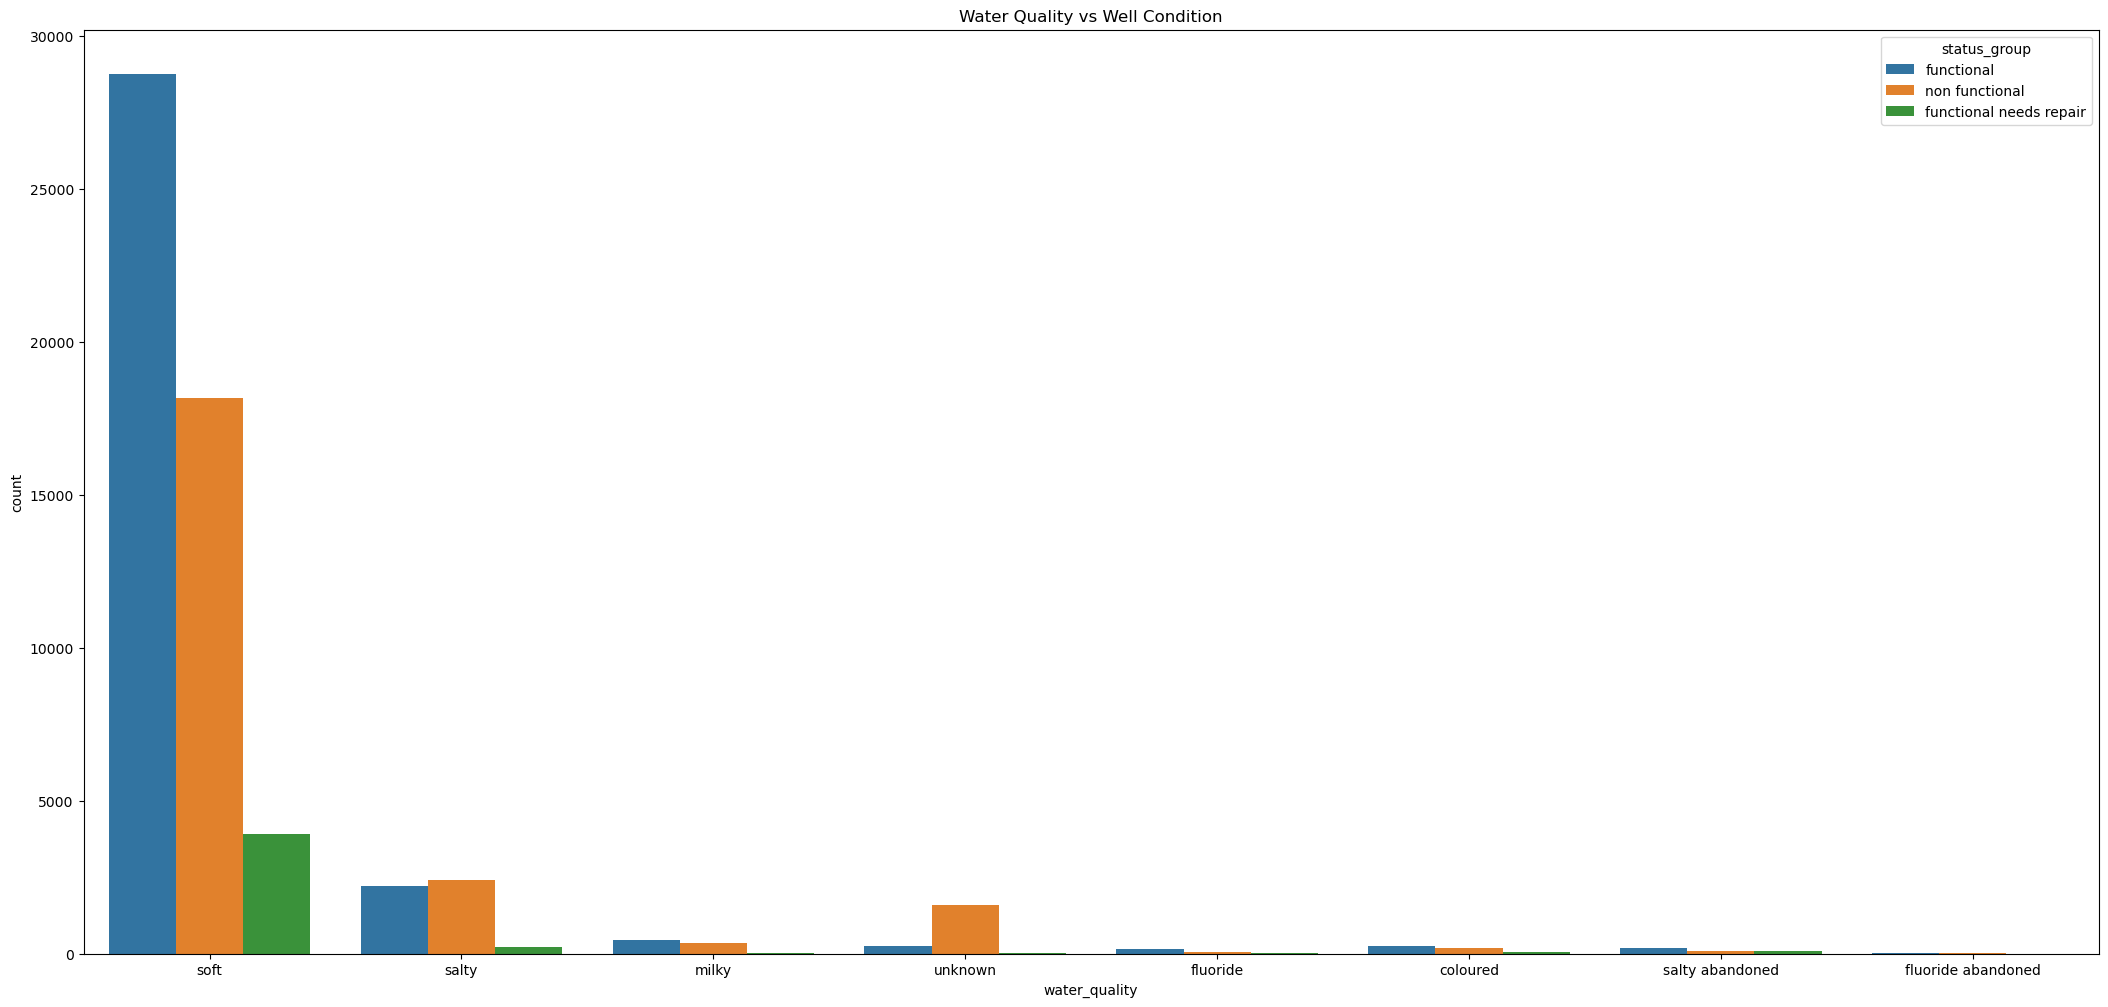

In [206]:
plt.figure(figsize=(26,12))
sns.countplot(x='water_quality', hue='status_group', data= train_data)
plt.title('Water Quality vs Well Condition')
plt.show()

#### Region Vs Well Condition

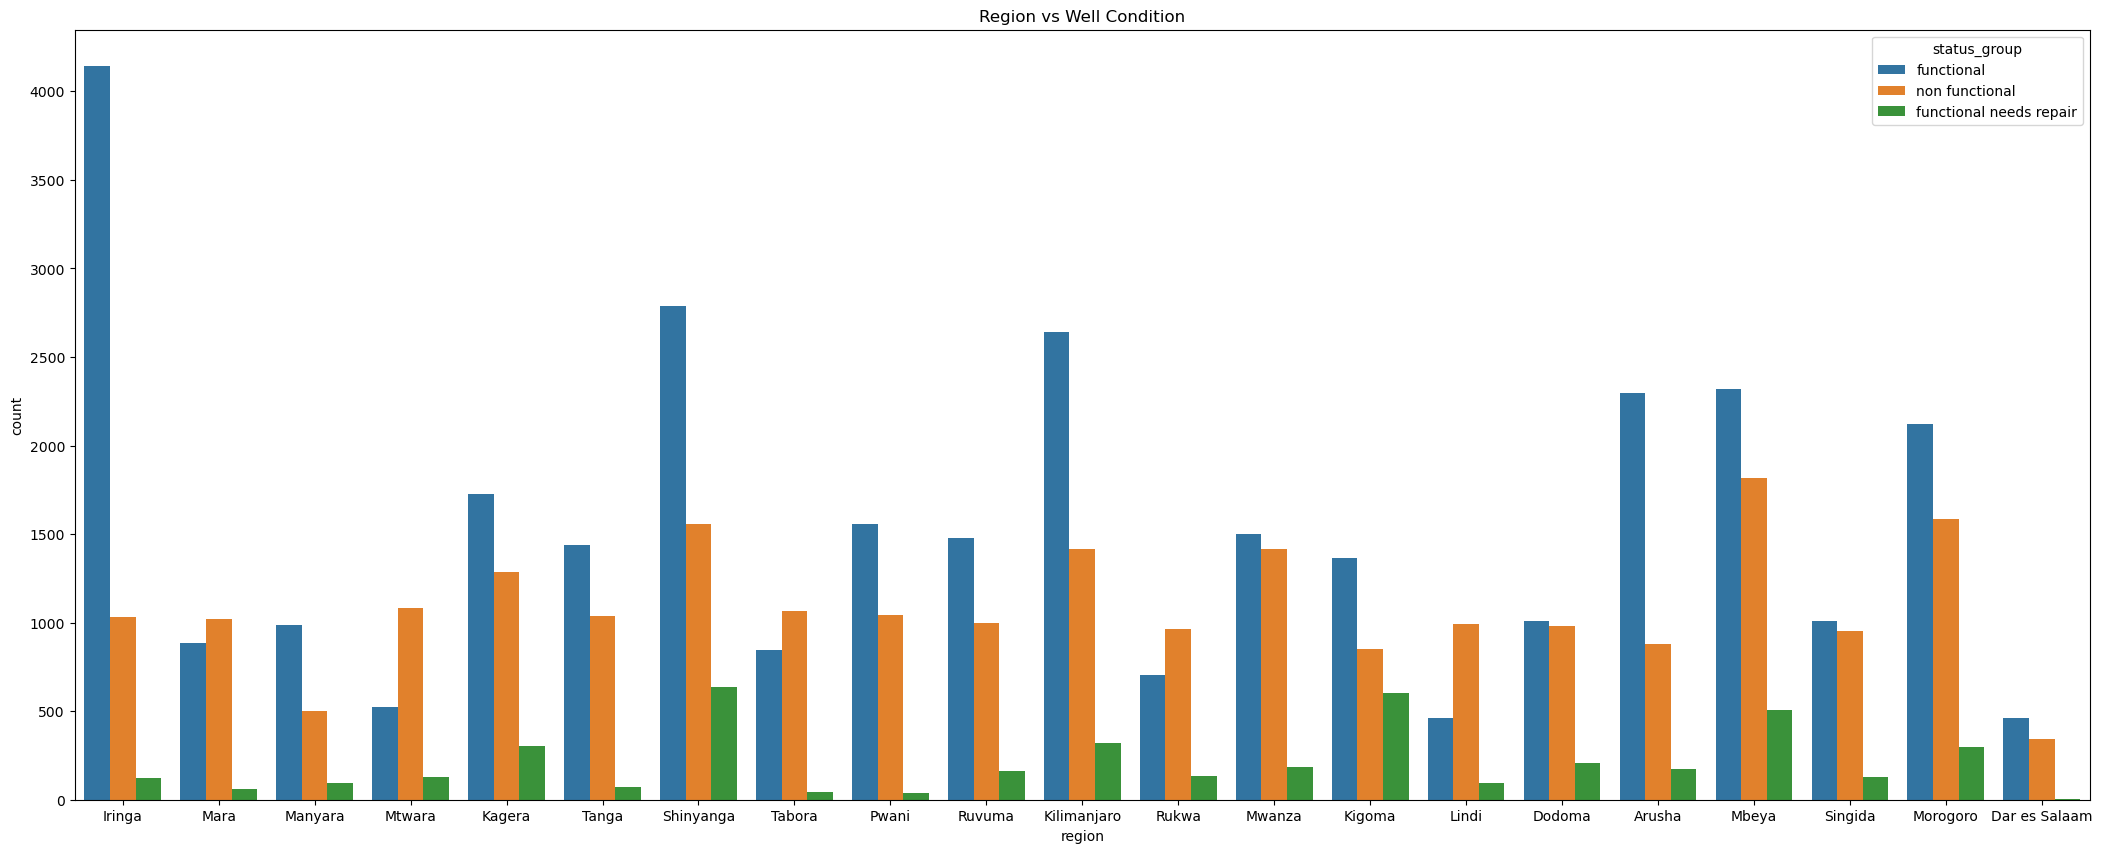

In [207]:
plt.figure(figsize=(26,10))
sns.countplot(x='region', hue='status_group', data= train_data)
plt.title('Region vs Well Condition')
plt.show()

## Multivariate Analysis

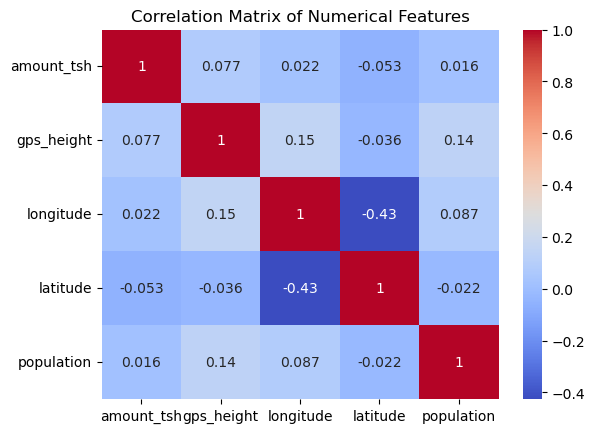

In [208]:
correlation_matrix = train_data[['amount_tsh', 'gps_height', 'longitude', 'latitude', 'population']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# Modelling

## Data preprocessing

In [ ]:
### Normalise/ Standarding the data

In [ ]:
### Handling Imbalanced data

In [ ]:
## Feature selection

In [ ]:
Select relevant features, use techniques such a correlation analysis
Dimensionality reduction

In [ ]:
## Model Selection

In [ ]:
Choose  algorithims depending on the problem.
Set up a baseline model

In [ ]:
## Model training

In [ ]:
Split data 
Train data
Hyperparameter tuning

In [ ]:
## Model evaluation

In [ ]:
Access performance
Cross validation

In [ ]:
## Model interpretation

In [ ]:
Analyze feature importance
Check for overfitting

In [ ]:
# Deployment

In [ ]:
Prepare the model for deployment

In [ ]:
Monitor performance

In [ ]:
## Documrentation and Reporting